In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Advanced Land Line Detection
===


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import gc      


% matplotlib inline

In [3]:

#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

def getimageobjpoints(x,y):
    objp = np.zeros((x*y,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')
 
    i = 0 
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
    # If found, add object points, image points
        if ret == True:
            i = i + 1 
            objpoints.append(objp)
            imgpoints.append(corners)

        # Draw and display the corners
            cv2.drawChessboardCorners(img, (x,y), corners, ret)
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite('output_images/'+ write_name, img)
            #cv2.imshow('img'+str(i), img)
            #cv2.waitKey(500)
            #plt.imshow(img)
            #plt.show()

getimageobjpoints(9,5)
getimageobjpoints(9,6)
getimageobjpoints(8,5)
getimageobjpoints(8,6)
print("Completed loading all the images")
        
#cv2.destroyAllWindows()

### Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

In [5]:
# import pickle

# img = cv2.imread('output_images/undist_calibration1.jpg')

# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[0],img.shape[1]),None,None)

# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# pickle.dump( dist_pickle, open( "calibration/wide_dist_pickle.p", "wb" ) )


In [4]:
import pickle

dist_pickle = pickle.load(open( "calibration/wide_dist_pickle.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


In [5]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def display_img(img,binary_output,title='Output Image',cmaptype='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=50)
    if cmaptype == None:
        ax2.imshow(binary_output)
    else:
        ax2.imshow(binary_output,cmap=cmaptype)
    ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

In [25]:
import ntpath
import pickle


print("Loaded camera calibration results")


def undistortimg(fname,mtx,dist,output_dir,visualize=False):
    # Test undistortion on an image
    print("Undistorting " + fname)
    img = cv2.imread(fname)

    # Do camera calibration given object points and image points
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(output_dir+'/undist_'+path_leaf(fname),dst)

    # Visualize undistortion
    if(visualize):
        display_img(img,dst,title='Undistorted Image')

def process_distorted_images(test_images):
    for idx,fname in enumerate(test_images):
        undistortimg(fname,mtx,dist,'output_images',visualize=False)

process_distorted_images(glob.glob('camera_cal/cal*.jpg'))
process_distorted_images(glob.glob('test_images/*.jpg'))

plt.close()



Loaded camera calibration results
Undistorting camera_cal/calibration1.jpg
Undistorting camera_cal/calibration10.jpg
Undistorting camera_cal/calibration11.jpg
Undistorting camera_cal/calibration12.jpg
Undistorting camera_cal/calibration13.jpg
Undistorting camera_cal/calibration14.jpg
Undistorting camera_cal/calibration15.jpg
Undistorting camera_cal/calibration16.jpg
Undistorting camera_cal/calibration17.jpg
Undistorting camera_cal/calibration18.jpg
Undistorting camera_cal/calibration19.jpg
Undistorting camera_cal/calibration2.jpg
Undistorting camera_cal/calibration20.jpg
Undistorting camera_cal/calibration3.jpg
Undistorting camera_cal/calibration4.jpg
Undistorting camera_cal/calibration5.jpg
Undistorting camera_cal/calibration6.jpg
Undistorting camera_cal/calibration7.jpg
Undistorting camera_cal/calibration8.jpg
Undistorting camera_cal/calibration9.jpg
Undistorting test_images/solidWhiteRight.jpg
Undistorting test_images/solidYellowLeft.jpg
Undistorting test_images/test1.jpg
Undistorti

In [19]:
import matplotlib.image as mpimg

#Convert to grayscale and apply sobel operator

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 130)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag > mag_thresh[0]) & (gradmag < mag_thresh[1])] = 1
    # Return the binary image
    return binary_output


def abs_sobel_thresh(img, orient='x', thresh=(20,100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combine(gradx,grady,mag_binary,dir_binary):
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def combine_binary(sxbinary,s_binary):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def combine_color_binary(sxbinary,s_binary):
    return np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

images = glob.glob('output_images/undist_test*.jpg')


def udacity_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 150)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

def pipeline(img):
    gradx = abs_sobel_thresh(img, orient='x', thresh=(40, 170))
    grady = abs_sobel_thresh(img, orient='y', thresh=(40, 170))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 170))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    gradient_combine = combine(gradx,grady,mag_binary,dir_binary)
    hls_image = hls_select(img,(130,255))
    final_img = combine_binary(hls_image,gradient_combine)
    color_img = combine_color_binary(hls_image,gradient_combine)
    return final_img

for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    
    #ksize=3
    final_img = pipeline(img)
    #display_img(img,final_img)
    #color_img,combine_binary = pipeline(img)
    #display_img(img,color_img,cmaptype=None)
    
plt.close()

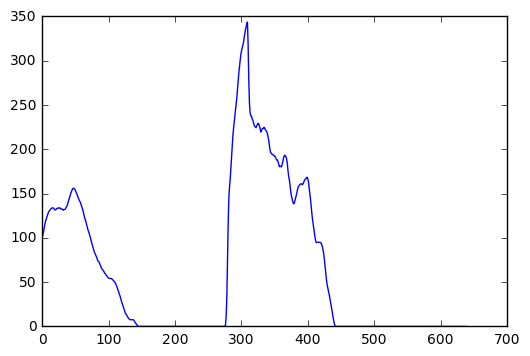

343.708984375


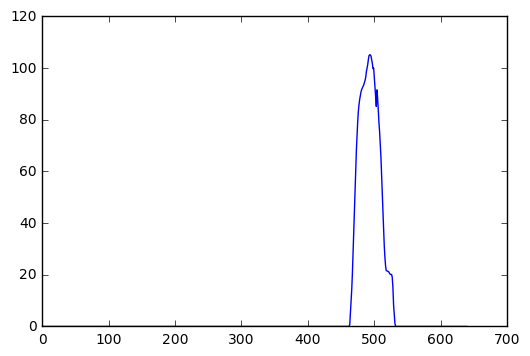

105.142578125


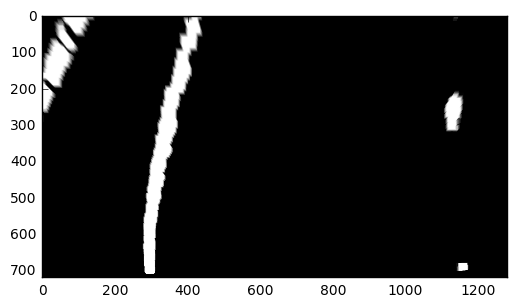

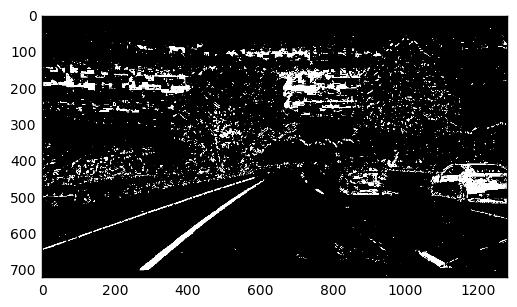

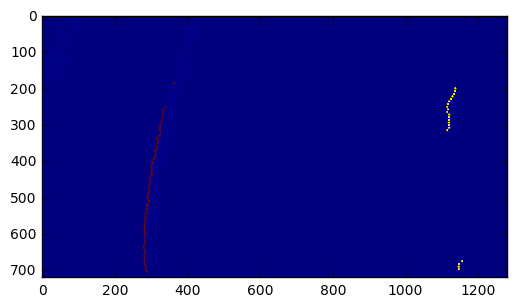

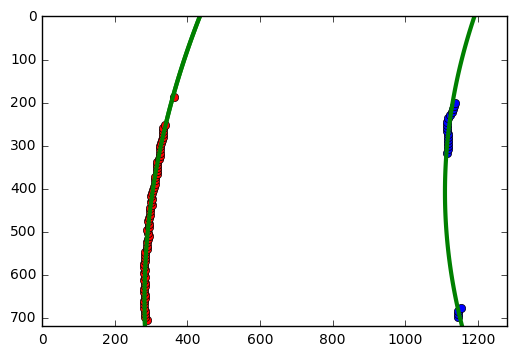

[  4.86143259e-04  -3.96938824e-01   1.18976625e+03] [  3.51241029e-04  -4.62396088e-01   4.33912302e+02]


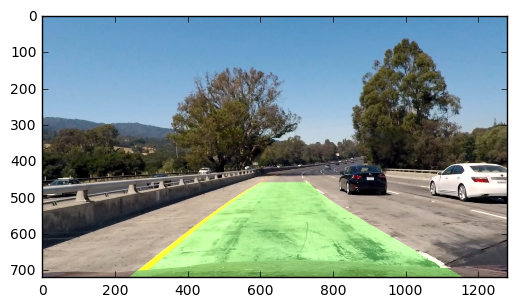

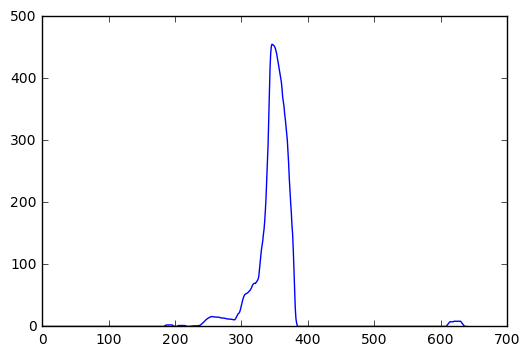

455.1875


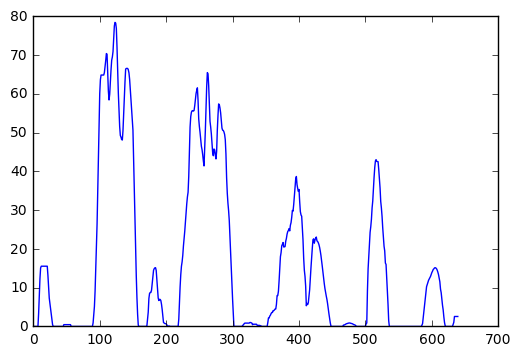

78.46875


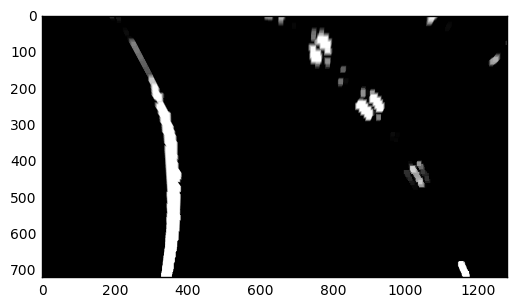

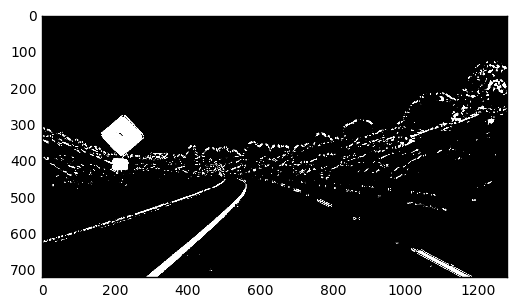

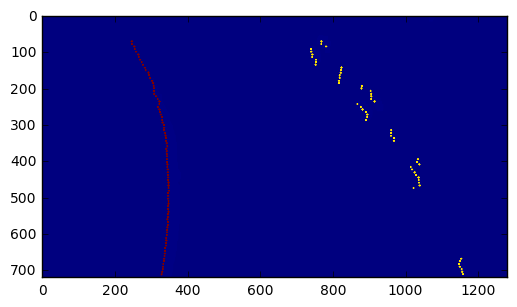

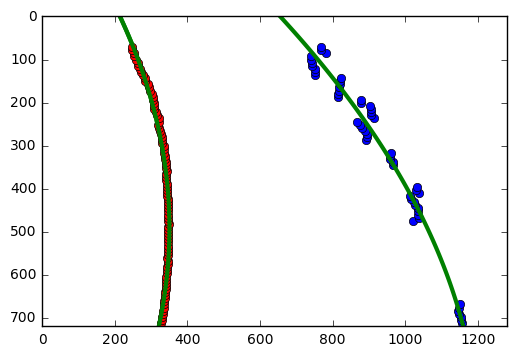

[ -5.43708396e-04   1.09135765e+00   6.55114799e+02] [ -5.62149085e-04   5.53288804e-01   2.14135743e+02]


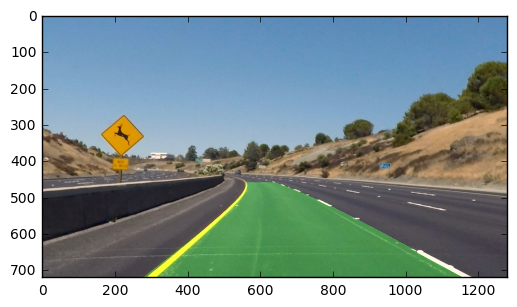

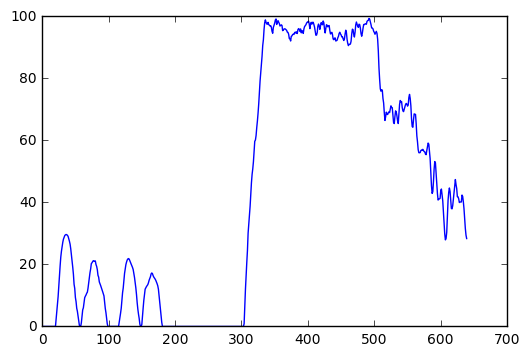

99.373046875


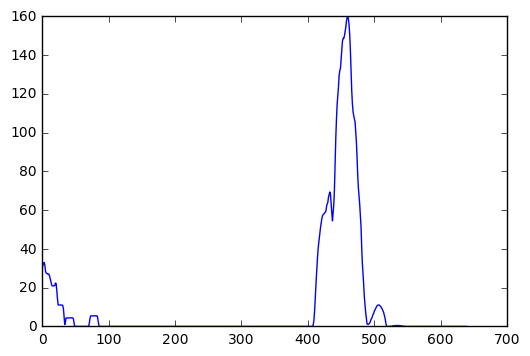

159.846679688


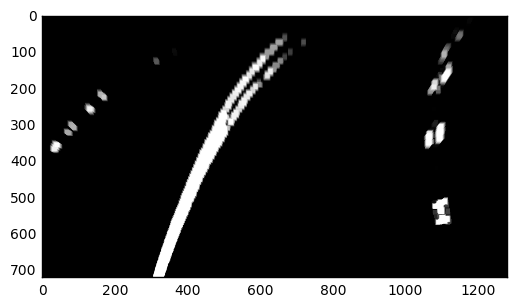

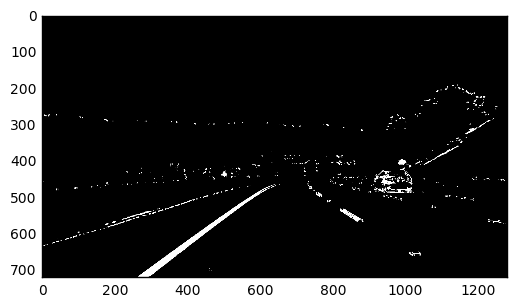

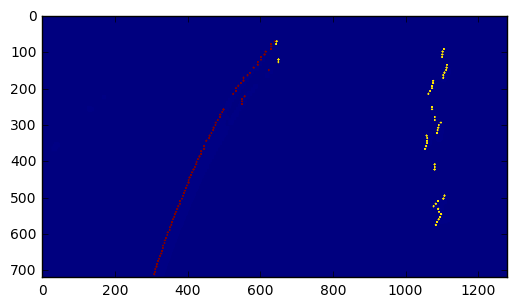

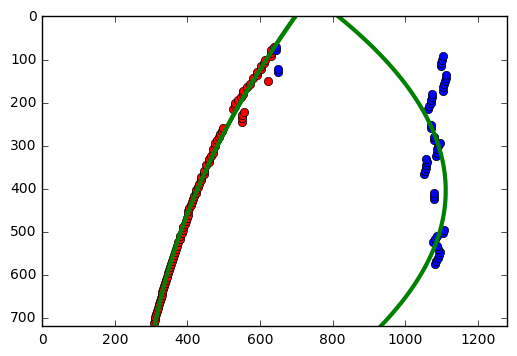

[ -1.80653053e-03   1.46188896e+00   8.15030572e+02] [  4.17178349e-04  -8.38673649e-01   6.96671791e+02]


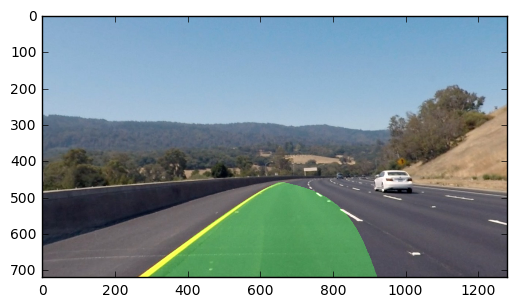

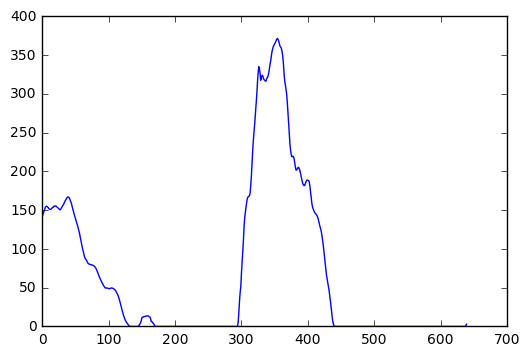

371.631835938


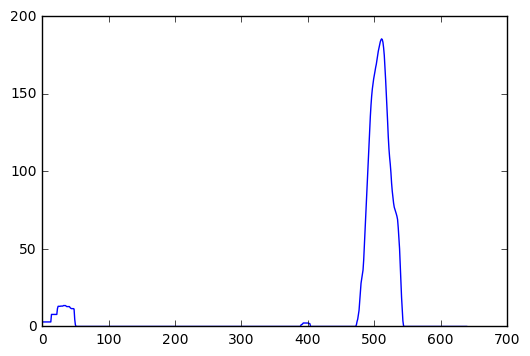

185.553710938


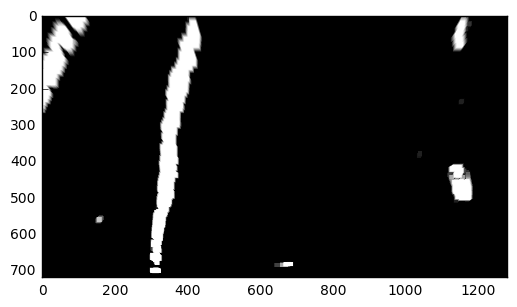

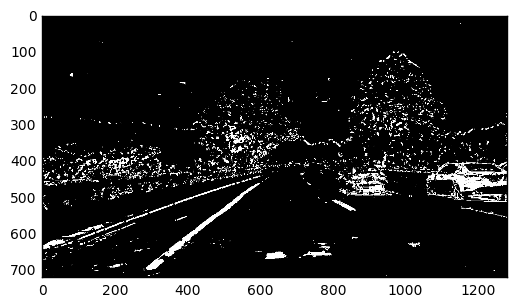

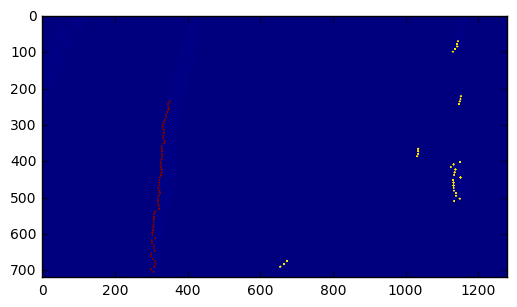

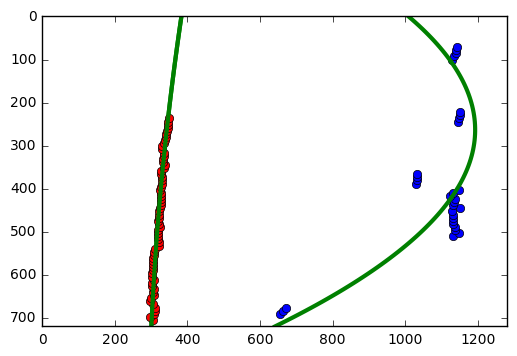

[ -2.64314692e-03   1.39242826e+00   1.00845893e+03] [  8.32399107e-05  -1.74793654e-01   3.83223691e+02]


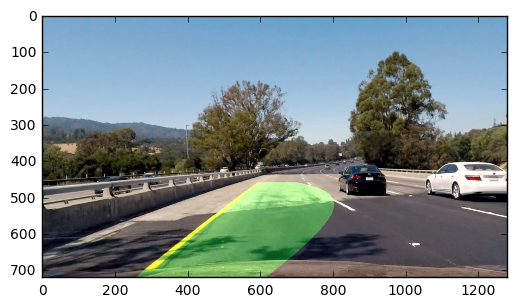

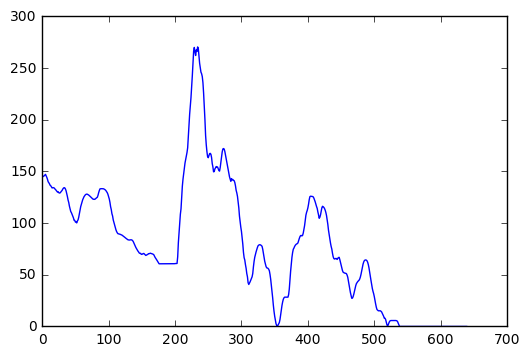

270.493164062


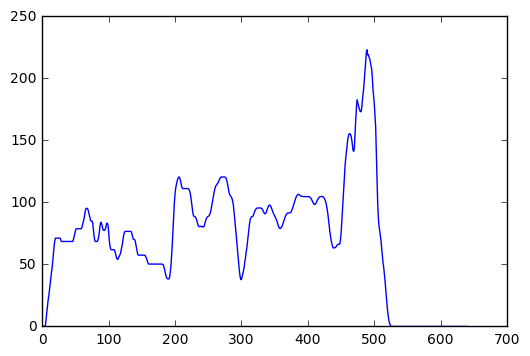

223.135742188


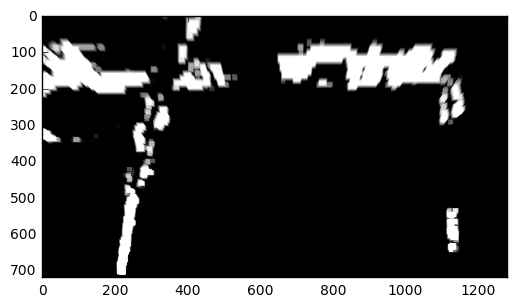

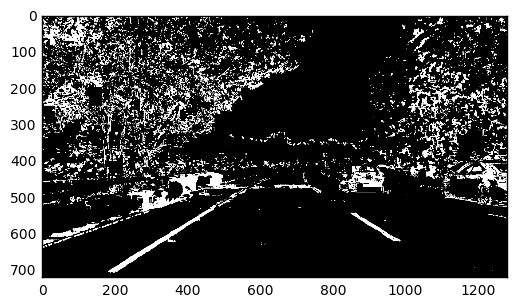

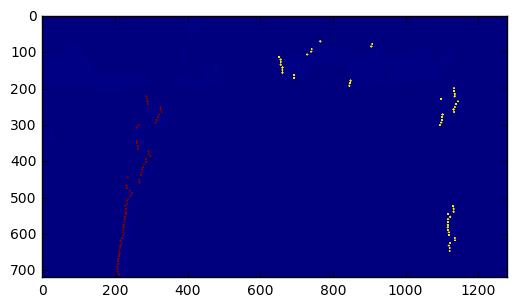

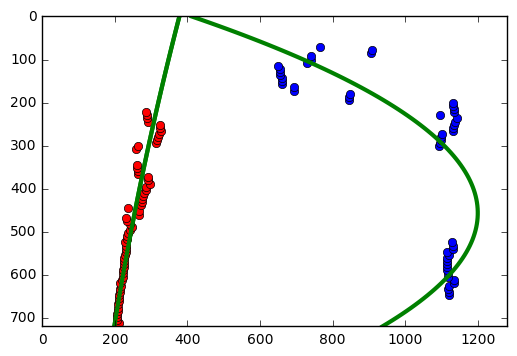

[ -3.78047925e-03   3.45094751e+00   4.11513442e+02] [  7.99296539e-05  -3.06311499e-01   3.77675145e+02]


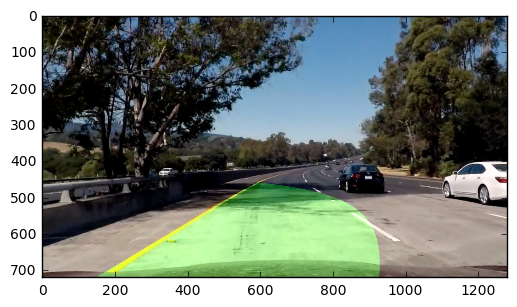

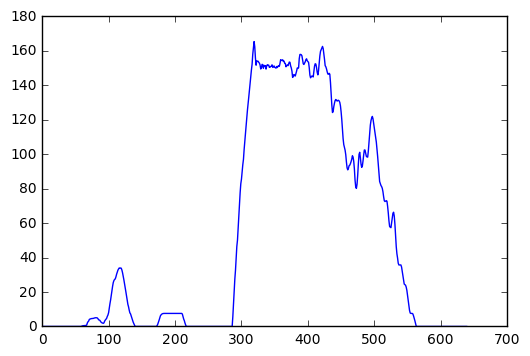

165.404296875


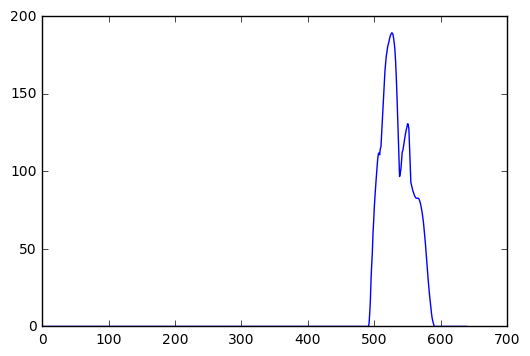

189.361328125


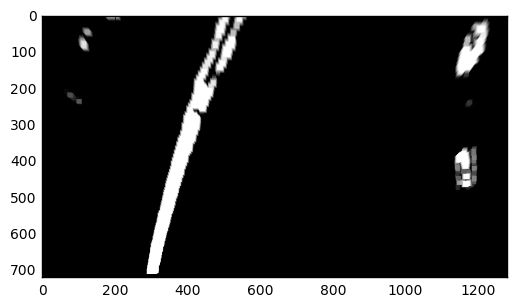

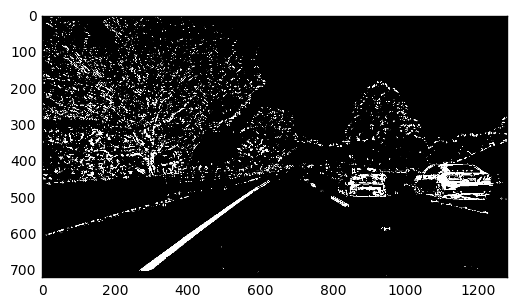

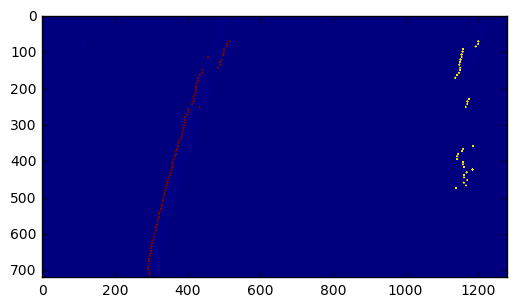

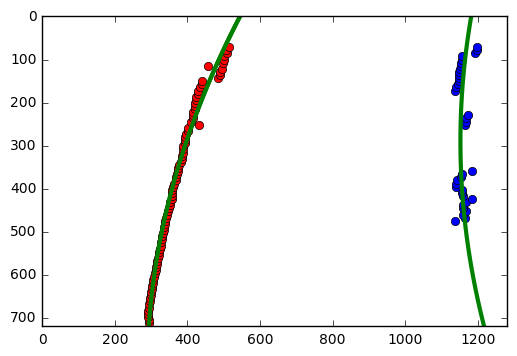

[  3.52822961e-04  -2.04627237e-01   1.18098812e+03] [  3.70577437e-04  -6.15433453e-01   5.44475296e+02]


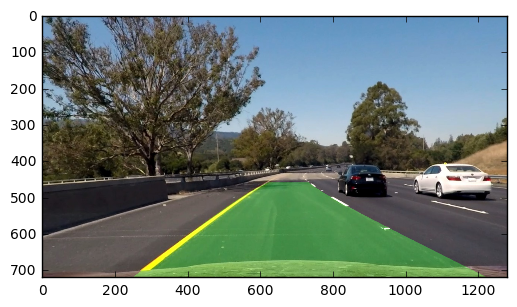

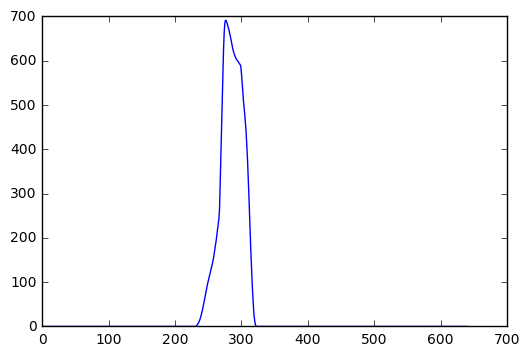

691.618164062


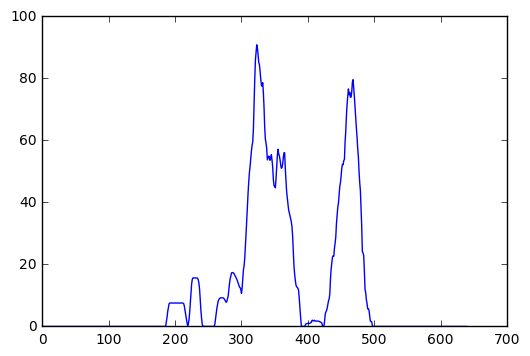

90.85546875


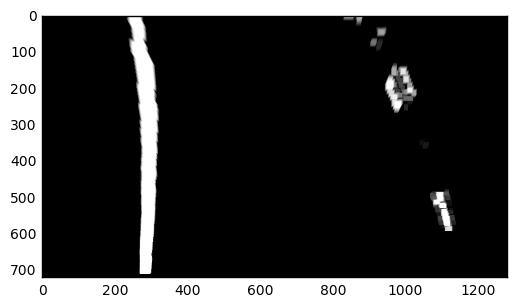

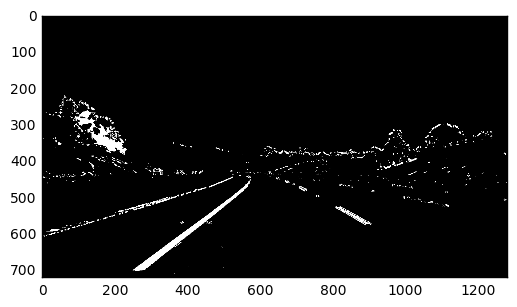

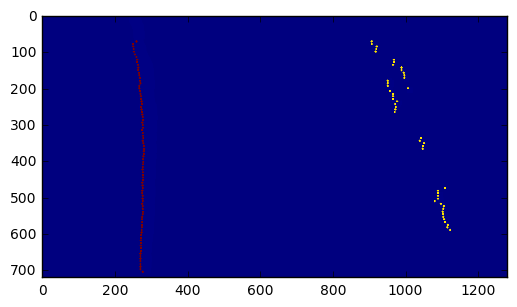

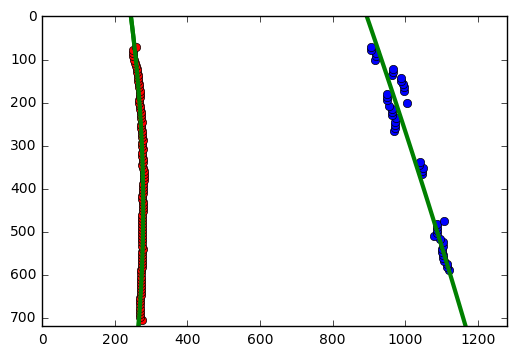

[ -4.18442261e-05   4.08187393e-01   8.93596628e+02] [ -1.71620486e-04   1.52466481e-01   2.44228465e+02]


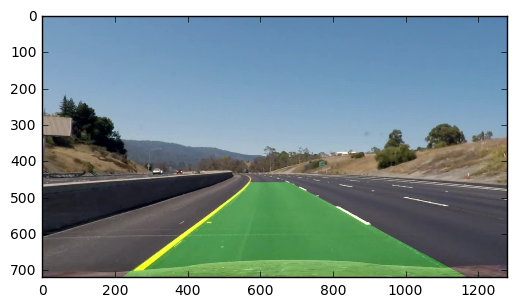

25020

In [29]:
def warp_image(img,debug=False):
    if debug:
        plt.imshow(img)
        plt.plot(100,720,'.')
        plt.plot(1200,720,'.')
        plt.plot(750,480,'.')
        plt.plot(570,480,'.')
        plt.plot(350,720,'.')
        plt.plot(950,720,'.')
        plt.plot(950,0,'.')
        plt.plot(350,0,'.')

    src=np.float32([(220,720),(1130,720),(724,460),(570,460)])
    dst=np.float32([(265,720),(1130,720),(1130,0),(265,0)])
    #dst=np.float32([(160,720),(1200,720),(1200,480),(160,480)])
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    return warped,M,Minv




# histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
# plt.plot(histogram)
# plt.show()

# left_side_x=[]
# left_side_y=[]
# past_cord = 0

# for i in reversed(range(10,100)):
#     histogram = np.sum(warped[i*warped.shape[0]/100:(i+1)*warped.shape[0]/100,0:warped.shape[1]/2], axis=0) 
#     xcord = int(np.argmax(histogram))
#     ycord = int(i*warped.shape[0]/100)
    
#     if(xcord==0 or ycord==0):
#         pass
#     if (ycord == 0 or xcord == 0):
#         pass
#     elif (abs(xcord-past_cord) > 100 and not (past_cord == 0)):
#         pass
#     else:
#         left_side_x.append(xcord)
#         left_side_y.append(ycord)
#         past_cord = xcord


# right_side_x=[]
# right_side_y=[]
# past_cord = 0
        
# for i in reversed(range(10,100)):
#     histogram = np.sum(warped[i*warped.shape[0]/100:(i+1)*warped.shape[0]/100,warped.shape[1]/2:warped.shape[1]], axis=0) 
#     xcord = int(np.argmax(histogram))+int(warped.shape[1]/2)
#     ycord = int(i*warped.shape[0]/100)
    
#     if(xcord == int(warped.shape[1]/2)):
#         pass
#     elif (ycord == 0 or xcord == 0):
#         pass 
#     elif (abs(xcord-past_cord) > 100 and not (past_cord == 0)):
#         pass
#     else:
#         right_side_x.append(xcord)
#         right_side_y.append(ycord)
#         past_cord = xcord

def getleftLanes(warped,minLimit,maxLimit):
    left_side_x=[]
    left_side_y=[]
    past_cord = 0
    
    for i in reversed(range(10,100)):
        histogram = np.sum(warped[i*warped.shape[0]/100:(i+1)*warped.shape[0]/100,0:warped.shape[1]/2], axis=0) 
        xcord = int(np.argmax(histogram))
        ycord = int(i*warped.shape[0]/100)
    
        if(xcord==0 or ycord==0):
            pass
        if (ycord == 0 or xcord == 0):
            pass
        elif (abs(xcord-past_cord) > 100 and not (past_cord == 0)):
            pass
        else:
            left_side_x.append(xcord)
            left_side_y.append(ycord)
            past_cord = xcord
    return left_side_x,left_side_y

def getrightLanes(warped,minLimit,maxLimit):
    right_side_x=[]
    right_side_y=[]
    past_cord = 0
        
    for i in reversed(range(10,100)):
        histogram = np.sum(warped[i*warped.shape[0]/100:(i+1)*warped.shape[0]/100,warped.shape[1]/2:warped.shape[1]], axis=0) 
        xcord = int(np.argmax(histogram))+int(warped.shape[1]/2)
        ycord = int(i*warped.shape[0]/100)
    
        if(xcord == int(warped.shape[1]/2)):
            pass
        elif (ycord == 0 or xcord == 0):
            pass 
        elif (abs(xcord-past_cord) > 200 and not (past_cord == 0)):
            pass
        else:
            right_side_x.append(xcord)
            right_side_y.append(ycord)
            past_cord = xcord
    return right_side_x,right_side_y

def scatter_plot(img,allX,allY,side=1,size=3):
        if side == 1:
            color = (192,128,128)
        else:
            color = (128,128,192)
        xy_array = np.column_stack((allX, allY)).astype(np.int32)
        for xy in xy_array:
            cv2.circle(img, (xy[0], xy[1]), size, color, -1)
        return img
    
def processImg(img,debug=False):
    binary_img = pipeline(img)
    warped,M,Minv = warp_image(binary_img)

    kernel = np.ones((3,3),np.uint8)

    warped = cv2.erode(warped,kernel,iterations=5)
    warped = cv2.dilate(warped,kernel,iterations=5)
    
    if debug:
        left_histogram = np.sum(warped[:,:int(warped.shape[1]/2)], axis=0)
        plt.plot(left_histogram)
        plt.show()
        print(left_histogram.max())
    
        right_histogram = np.sum(warped[:,int(warped.shape[1]/2):], axis=0)
        plt.plot(right_histogram)
        plt.show()
        print(right_histogram.max())
    
    
        plt.imshow(warped,cmap='gray')
        plt.show()
    
        plt.imshow(binary_img,cmap='gray')
        plt.show()
        
    left_side_x,left_side_y = getleftLanes(warped,minLimit=0,maxLimit=warped.shape[1]/2)
    
    right_side_x,right_side_y = getrightLanes(warped,minLimit=warped.shape[1]/2,maxLimit=warped.shape[1])
            
    if debug:
        scattered_img = scatter_plot(warped,left_side_x,left_side_y)
        scattered_img = scatter_plot(scattered_img,right_side_x,right_side_y,side=2)
        plt.imshow(scattered_img)
        plt.show()
    
    
    ###Part 2 ####
    
    
    
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    
    left_fit = np.polyfit(left_side_y, left_side_x, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    
    if debug:
        plt.plot(left_fitx, yvals, color='green', linewidth=3)
    
    
    if(len(right_side_x)==0):
        cv2.imwrite('problem_img.jpg',img)

    right_fit = np.polyfit(right_side_y,right_side_x,2)
    
    
    #if(left_fit[0]*right_fit[0]<0 or left_fit[1]*right_fit[1]<0):
    #    right_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + (625 + left_fit[2])
        #print("Swapped")
        #print(left_fit[0]*right_fit[0])
        #print(left_fit[1]*right_fit[1])
    #else:
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    
    if debug:
        plt.plot(left_side_x, left_side_y, 'o', color='red')
        plt.plot(right_side_x, right_side_y, 'o', color='blue')
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, yvals, color='green', linewidth=3)
        plt.plot(right_fitx, yvals, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images    
        plt.show()
    
        print(right_fit,left_fit)
    
    
    y_eval = np.max(yvals)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                                 /np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                    /np.absolute(2*right_fit[0])
    
    #print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    left_side_y_float = np.array(left_side_y)
    left_side_x_float = np.array(left_side_x)
    
    
    right_side_y_float = np.array(right_side_y)
    right_side_x_float = np.array(right_side_x)
    
    left_fit_cr = np.polyfit(left_side_y_float*ym_per_pix, left_side_x_float*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_side_y_float*ym_per_pix, right_side_x_float*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

# img = cv2.imread('output_images/undist_test5.jpg')
# result = processImg(img)
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.show()

images = glob.glob('test_images/test*.jpg')

dist_pickle = pickle.load(open( "calibration/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def finalProcessImg(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    result = processImg(dst,debug=False)
    return result
  

for idx,fname in enumerate(images):
    #print(fname)
    img = cv2.imread(fname)
    #ksize=3
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    result = processImg(dst,debug=True)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()
    #display_img(img,final_img)
    #color_img,combine_binary = pipeline(img)
    #display_img(img,color_img,cmaptype=None)


# img = cv2.imread("problem_img.jpg")
# dst = cv2.undistort(img, mtx, dist, None, mtx)
# result = processImg(dst,debug=True)
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.show()

###Cleanup after plotting

plt.clf()

plt.close()
gc.collect()
            

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(finalProcessImg) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<07:01,  2.99it/s]

  0%|          | 2/1261 [00:00<06:21,  3.30it/s]

  0%|          | 3/1261 [00:00<05:51,  3.58it/s]

  0%|          | 4/1261 [00:01<05:29,  3.82it/s]

  0%|          | 5/1261 [00:01<05:15,  3.98it/s]

  0%|          | 6/1261 [00:01<05:05,  4.10it/s]

  1%|          | 7/1261 [00:01<05:03,  4.14it/s]

  1%|          | 8/1261 [00:01<04:57,  4.22it/s]

  1%|          | 9/1261 [00:02<04:54,  4.24it/s]

  1%|          | 10/1261 [00:02<04:51,  4.29it/s]

  1%|          | 11/1261 [00:02<04:49,  4.32it/s]

  1%|          | 12/1261 [00:02<04:49,  4.32it/s]

  1%|          | 13/1261 [00:03<04:48,  4.33it/s]

  1%|          | 14/1261 [00:03<04:45,  4.36it/s]

  1%|          | 15/1261 [00:03<04:43,  4.40it/s]

  1%|▏         | 16/1261 [00:03<04:40,  4.44it/s]

  1%|▏         | 17/1261 [00:03<04:40,  4.43it/s]

  1%|▏         | 18/1261 [00:04<04:41,  4.42it/s]

  2%|▏         | 19/1261 [00:04<04:39,  4.44it/

In [196]:
len(left_side_y)

58

In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))